In [1]:
#!pip install pandas 
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import copy
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from lvis import LVIS

Matplotlib is building the font cache; this may take a moment.


In [2]:
config_file = './configs/custom/faster_rcnn_r50_fpn_1x_lvis.py'
checkpoint_file = './work_dirs/baseline_epoch_12.pth'
# model = init_detector(config_file, checkpoint_file, device='cuda:0')
model = init_detector(config_file, checkpoint_file, device='cpu')
init_weights = copy.deepcopy(model.roi_head.bbox_head.fc_cls.weight.data.cpu().numpy())
cls_weights_baseline = np.sqrt(np.sum((init_weights)**2, axis = 1))

Step 0
Step 1
Step 3
Step 4
Step 5
Step 6


In [3]:
config_file = './configs/custom/gs_faster_rcnn_r50_fpn_1x_lvis_with0_bg8.py'
checkpoint_file = 'work_dirs/gs_faster_rcnn_r50_fpn_1x_lvis_with0_bg8_naive/epoch_12.pth'
# model = init_detector(config_file, checkpoint_file, device='cuda:0')
model = init_detector(config_file, checkpoint_file, device='cpu')
init_weights = copy.deepcopy(model.roi_head.bbox_head.fc_cls.weight.data.cpu().numpy())
cls_weights_bags = np.sqrt(np.sum((init_weights)**2, axis = 1))

Step 0
Step 1
Step 3
Step 4
Step 5
Step 6


In [4]:
config_file = './configs/custom/gs_faster_rcnn_r50_fpn_1x_lvis_with0_bg8.py'
checkpoint_file = 'work_dirs/gs_faster_rcnn_r50_fpn_1x_lvis_with0_bg8_frozen_lradjusted/epoch_12.pth'
# model = init_detector(config_file, checkpoint_file, device='cuda:0')
model = init_detector(config_file, checkpoint_file, device='cpu')
init_weights = copy.deepcopy(model.roi_head.bbox_head.fc_cls.weight.data.cpu().numpy())
cls_weights_wbags = np.sqrt(np.sum((init_weights)**2, axis = 1))

Step 0
Step 1
Step 3
Step 4
Step 5
Step 6


In [5]:
train_ann_file = './data/lvis_v1/annotations/lvis_v1_train.json'
lvis_train = LVIS(train_ann_file)
train_catsinfo = lvis_train.cats

In [10]:
cat_info = {}
for cid, cate in train_catsinfo.items():
    if True or cate['instance_count'] > 100 and cate['instance_count'] < 1000:
        cat_info[cid]={}
        cat_info[cid]['id'] = cid
        cat_info[cid]['name'] = cate['name']
        cat_info[cid]['instance_count'] = int(cate['instance_count'])
        cat_info[cid]['cls_weight_baseline'] = cls_weights_baseline[cid-1]
        cat_info[cid]['cls_weight_bags'] = cls_weights_bags[cid-1]  
        cat_info[cid]['cls_weight_wbags'] = cls_weights_wbags[cid-1]  

In [13]:
k = 10
df = pd.DataFrame.from_dict(cat_info, orient='index')
df.sort_values(by='instance_count', inplace=True, ascending=False)
df.reset_index(drop = True, inplace=True)
df['cls_weight_baseline']=df['cls_weight_baseline'].rolling(k).mean()
df['cls_weight_bags']=df['cls_weight_bags'].rolling(k).mean()
df['cls_weight_wbags']=df['cls_weight_bags'].rolling(k).mean()
df.head()


,id,name,instance_count,cls_weight_baseline,cls_weight_bags,cls_weight_wbags
0,45,banana,50552,NaN,NaN,NaN
1,127,book,33353,NaN,NaN,NaN
2,217,carrot,18049,NaN,NaN,NaN
3,12,apple,17451,NaN,NaN,NaN
4,827,pole,14276,NaN,NaN,NaN


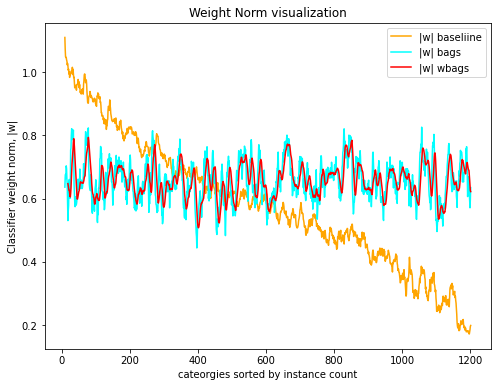

In [14]:
df.plot(y=['cls_weight_baseline','cls_weight_bags','cls_weight_wbags'], title ="Weight Norm visualization",
        ylabel="Classifier weight norm, |w|", xlabel = "cateorgies sorted by instance count",
        color=['orange', 'cyan', 'red'], label=["|w| baseliine", "|w| bags", "|w| wbags"], figsize=(8,6))
plt.savefig("figures/wt_norm_visual.png")

In [20]:
# plt.plot(sorted(list(cls_weights))[::-1]);

NameError: name 'cls_weights' is not defined

In [14]:
!ls

000000005802.jpg	       lvis_v1_val_classwise_AP.npy
1			       lvis_v1_val_g1_classwise_AP.npy
LICENSE			       lvis_v1_val_g4_classwise_AP.npy
README.md		       lvis_v1_val_g_mini_classwise_AP.npy
ap_g1.npy		       lvis_v1_val_naive_classwise_AP.npy
ap_g2.npy		       lvis_v1_val_subset_of_subset_classwise_AP.npy
ap_g3.npy		       lvis_v1_val_weighted_classwise_AP.npy
ap_g4.npy		       mmdet
checkpoints		       mmdet.egg-info
classwise_AP.npy	       output_naive.pkl
configs			       output_weighted.pkl
data			       pytest.ini
demo			       read_pickle.ipynb
docker			       requirements
docs			       requirements.txt
eval-results		       resources
eval_testing		       results
figures			       setup.cfg
g1.pkl			       setup.py
g2.pkl			       split_category_wise.ipynb
g3.pkl			       tests
g4.pkl			       tools
load_json.ipynb		       visualize_cls_weights.ipynb
lvis_v1_rags_classwise_AP.npy  work_dirs


# Category AP

In [1]:
import numpy as np
import os

import json
with open('./data/lvis_v1/annotations/lvis_v1_' + 'train' + '.json') as f:
    data = json.load(f)
data['categories'] = sorted(data['categories'], key = lambda k: k['instance_count'])


In [2]:
def getCatToAP(path):
    aps = np.load(path,allow_pickle=True)
    catToAP = {}
    for i,ap in enumerate(aps):
            if i == 0:
                continue
            try:
                catToAP[ap[0]] = float(ap[1])
            except:
                pass
            try:
                catToAP[ap[2]] = float(ap[3])
            except:
                pass
            try:
                catToAP[ap[4]] = float(ap[5])
            except:
                pass
    return catToAP

path_wbags = 'lvis_v1_val_weighted_classwise_AP.npy'
path_bags = 'lvis_v1_val_naive_classwise_AP.npy'
path_base = ''

catToAPNaive = getCatToAP(path_bags)
catToAPWeighted = getCatToAP(path_wbags)

apList1 = []
for cat in data['categories']:
    apList1.append(catToAPNaive[cat['name']])
    
apList2 = []
for cat in data['categories']:
    apList2.append(catToAPWeighted[cat['name']])

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

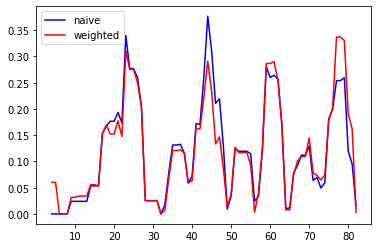

In [11]:
import pandas as pd
df = pd.DataFrame({'B': apList2[:200], 'A':apList1[:200]})
df = df.dropna()
plt.figure()
plt.plot(list(df.rolling(5).mean()['A']),color='blue',alpha=1)
plt.plot(list(df.rolling(5).mean()['B']),color='red',alpha=1)
plt.legend(['naive','weighted'])
plt.show()

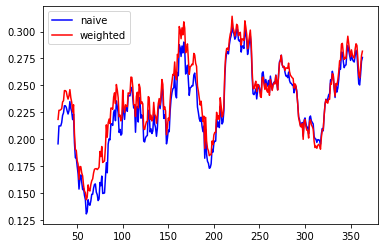

In [7]:
df = pd.DataFrame({'B': apList2[200:(200+412)], 'A':apList1[200:(200+412)]})
df = df.dropna(
plt.figure()
plt.plot(list(df.rolling(30).mean()['A']),color='blue',alpha=1)
plt.plot(list(df.rolling(30).mean()['B']),color='red',alpha=1)
plt.legend(['naive','weighted'])
plt.show()

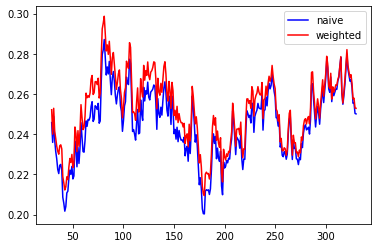

In [8]:
df = pd.DataFrame({'B': apList2[(200+412):(200+412+334)], 'A':apList1[(200+412):(200+412+334)]})
df = df.dropna()
plt.figure()
plt.plot(list(df.rolling(30).mean()['A']),color='blue',alpha=1)
plt.plot(list(df.rolling(30).mean()['B']),color='red',alpha=1)
plt.legend(['naive','weighted'])
plt.show()

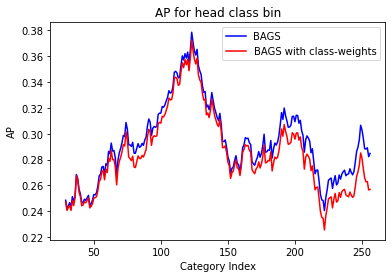

In [16]:
df = pd.DataFrame({'B': apList2[(200+412+334):], 'A':apList1[(200+412+334):]})
df = df.dropna()
plt.figure()
plt.plot(list(df.rolling(30).mean()['A']),color='blue',alpha=1)
plt.plot(list(df.rolling(30).mean()['B']),color='red',alpha=1)
plt.legend(['BAGS','BAGS with class-weights'])
plt.ylabel('AP')
plt.xlabel('Category Index')
plt.title('AP for head class bin')
plt.show()

In [13]:
for cat in data['categories']:
    print(cat['instance_count'])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
24
24
24
24
24
24
24
24
25
25
25
25
26
26
26
26
26
27
27
27
27
27
28
28
28
28
28
28
29
29
29
29
29
29
30
30
31
31
31
31
32
32
32
32
32
33


In [18]:
import numpy as np
import torch


In [19]:
a = torch.load('./data/lvis_v1/pred_slice_with0.pt')

In [20]:
a

tensor([[  0,   2],
        [  2, 201],
        [203, 413],
        [616, 335],
        [951, 258]])

In [23]:
c = [0,0,0,0]

for cat in data['categories']:
    if cat['instance_count'] < 10:
        c[0] += cat['instance_count']
    elif cat['instance_count'] < 100:
        c[1] += cat['instance_count']
    elif cat['instance_count'] < 1000:
        c[2] += cat['instance_count']
    else:
        c[3] += cat['instance_count']
        
    

In [24]:
c

[770, 16328, 116149, 1136894]